In [1]:
import pandas as pd
import numpy as np
import scipy as sc
from scipy.stats import entropy
import re
from collections import Counter
from sklearn import feature_extraction, tree, model_selection, metrics
from yellowbrick.features import Rank2D
from yellowbrick.features import RadViz
from yellowbrick.features import ParallelCoordinates
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import tldextract



In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
#  11392240 malicious data from https://data.netlab.360.com/dga/
malicious=pd.read_csv('dga.txt', delimiter = "\t", header=None, names=['DGA family', '.com', 'Domian, Start', 'end of valid time(UTC)'])
#malicious.shape
malicious.sample(5)
#malicious['DGA family'].value_counts()

,DGA family,.com,"Domian, Start",end of valid time(UTC)
1366473,banjori,lpbtowupblossomylixuf.com,1970-01-01 00:00:00,2030-01-01 00:00:00
1055869,banjori,dnwqellefrictionlessv.com,1970-01-01 00:00:00,2030-01-01 00:00:00
1149693,banjori,lvshbyplaywobb.com,1970-01-01 00:00:00,2030-01-01 00:00:00
280830,emotet,cxpmujobmughhrkw.eu,2014-11-20 17:15:00,2030-01-01 00:00:00
851168,rovnix,adb1g7vq38sspf4f55.cn,1970-01-01 00:00:00,2030-01-01 00:00:00


In [5]:
# To select DGA family which has a high number of domains, domain name include numbers
# Rovnix sample is similar to the sample used in the online lecture of 
# Supervised machine learning in security applications (2018, Charles Givre, O’Reilly)
# Teacher Giver achieved over 99% accuracy with ML models
malicious_rovnix=malicious[malicious['DGA family']== 'rovnix']

In [6]:
# assign 1 to malicious domain names
malicious_rovnix.insert(loc=0, column='IsDGA', value=1)

In [7]:
malicious_rovnix.sample(5)

,IsDGA,DGA family,.com,"Domian, Start",end of valid time(UTC)
744498,1,rovnix,17atzmwgsbvhn6qw26.net,1970-01-01 00:00:00,2030-01-01 00:00:00
850787,1,rovnix,my14ds1lc3lt1c1gwb.ru,1970-01-01 00:00:00,2030-01-01 00:00:00
804817,1,rovnix,crxih6u34gozqqrom4.com,1970-01-01 00:00:00,2030-01-01 00:00:00
777514,1,rovnix,dk157bmqfch5uquqo8.net,1970-01-01 00:00:00,2030-01-01 00:00:00
830417,1,rovnix,c8xcfj2h5ervdweopt.com,1970-01-01 00:00:00,2030-01-01 00:00:00


In [8]:
# include only two columns 'IsDGA' and '.com'
malicious_rovnix_final=malicious_rovnix.loc[:, ['IsDGA', '.com']]

In [9]:
#one million benign data from https://data.netlab.360.com/feeds/dga/dga.txt
benign=pd.read_csv('top-1m.csv')
benign.shape

(999999, 2)

In [10]:
benign.sample(10)

,1,google.com
315378,315380,googlegroups.com.multi.uribl.com
293337,293339,ovo.zendesk.com
729693,729695,www.baidu.cn
674417,674419,www.circlek.com.vn
630717,630719,www.cminds.com
398316,398318,psv64-1.daxab.com
918478,918480,grbjppn.icu
841736,841738,vcentertainment.com
701343,701345,www.optimumsuite.com
708771,708773,crazycooking.rqtech.net


In [11]:
#Assign 0 to benign domain names
benign.insert(loc=0, column='IsDGA', value=0)

In [12]:
benign.sample(5)

,IsDGA,1,google.com
942723,0,942725,sxazgprlz.com
551830,0,551832,saptechnical.com
82805,0,82807,ecaap.fidelity.com
880716,0,880718,r4.sn-42u-nbose.googlevideo.com
701026,0,701028,www.karaoke-soft.com


In [13]:
benign = benign.rename(columns={'google.com':'.com'})

In [14]:
#df benign_final includes only two columns 'IsDGA' and '.com'
benign_final=benign.loc[:179990, ['IsDGA', '.com']]
benign_final.shape

(179991, 2)

In [15]:
benign_final.sample(5)

,IsDGA,.com
142721,0,m3.aytxmbg.com
99452,0,m14.nnryeuh.me
144756,0,m16.jbspqko.biz
51898,0,scontent-bom1-2.cdninstagram.com
179950,0,r8---sn-w5nuxa-c33l6.googlevideo.com


In [16]:
# merge df benign and df DGA
domain_final = pd.concat( [benign_final, malicious_rovnix_final])

In [17]:
domain_final.sample(20)

,IsDGA,.com
47776,0,instagram.fhkg3-1.fna.fbcdn.net
22688,0,iot.smartmidea.net
85915,0,grnhse-dochouse-prod.s3.amazonaws.com
16583,0,play.wetvinfo.com
119240,0,m13.oapwxiu.com
849063,1,868j73tgcssgcxvj1i.net
148092,0,m28.akpsxcf.com
134464,0,m8.uksjnxz.com
810036,1,vzy3cwpl32jk1r38zf.ru
122259,0,sumsel.tribunnews.com


In [18]:
domain_final.shape

(359982, 2)

In [19]:
domain_final['IsDGA'].value_counts()

1    179991
0    179991
Name: IsDGA, dtype: int64

In [20]:
#To separate only domain name into Domain column using tldextract
domain_final['Domain'] = domain_final['.com'].apply(lambda url: tldextract.extract(url).domain)

In [21]:
domain_final.sample(10)

,IsDGA,.com,Domain
112428,0,hanguo001.v2ray008.top,v2ray008
169516,0,scripts.donglogs.com,donglogs
106258,0,iad08-convex.dotomi.com,dotomi
841782,1,6lep1vzpj3ly4mgcs4.net,6lep1vzpj3ly4mgcs4
788585,1,nxeny7p14l3k5bpg4e.cn,nxeny7p14l3k5bpg4e
112260,0,techadsmedia.com,techadsmedia
766729,1,73fliusiirskacg3r1.com,73fliusiirskacg3r1
37780,0,engadget.com,engadget
818806,1,81mgutgk8pp18s6bk8.com,81mgutgk8pp18s6bk8
16189,0,jabraxpressonlineprdstor.blob.core.windows.net,windows


In [22]:
# Add two features: the length of domain and digits
domain_final['Length'] = domain_final['Domain'].str.len()
domain_final['Numbers'] = domain_final['Domain'].str.count('[0-9]')

In [23]:
# calculate shannon's entropy
def calcEntropy(x):
    p, lens = Counter(x), np.float(len(x))
    return -sum(count/lens * np.log2(count/lens) for count in p.values())

In [24]:
# Add entropy feature
domain_final['Entropy'] = [calcEntropy(x) for x in domain_final['Domain']]

In [25]:
domain_final.sample(5)

,IsDGA,.com,Domain,Length,Numbers,Entropy
144202,0,m8.eypzztn.net,eypzztn,7,0,2.521641
811006,1,zrikljud2w1ui86ivs.biz,zrikljud2w1ui86ivs,18,4,3.794653
761054,1,yp43ssznt2fnu8b6ov.biz,yp43ssznt2fnu8b6ov,18,5,3.947703
812860,1,fzh6e1qdm4t3quzk7v.ru,fzh6e1qdm4t3quzk7v,18,5,3.947703
163741,0,m41.qxxgtwu.com,qxxgtwu,7,0,2.521641


In [26]:
# function for indexing first digit
def first_digit_index(x):
    n = re.search ("\d", x)
    if n:
        index = n.start()
        return index
    else:
        return -1

In [27]:
# add one feature: first_digit_index
domain_final['first_digit_index']= domain_final ['Domain'].apply(first_digit_index)

In [72]:
domain_final.sample(20)

,IsDGA,.com,Domain,Length,Numbers,Entropy,first_digit_index,vowel_consonant_ratio
153074,0,m30.eizcott.in,eizcott,7,0,2.521641,-1,0.750000
805603,1,riuc21dgobtf7wsqmx.biz,riuc21dgobtf7wsqmx,18,3,4.169925,4,0.250000
708192,1,g2gtdkenkrpbn7a755.ru,g2gtdkenkrpbn7a755,18,5,3.614369,1,0.181818
796368,1,7e1advqrypl12vrgi8.cn,7e1advqrypl12vrgi8,18,5,3.836592,0,0.300000
120253,0,m29.zimyclf.com,zimyclf,7,0,2.807355,-1,0.166667
772060,1,e3fykbqrnxpaojetml.com,e3fykbqrnxpaojetml,18,1,4.058814,1,0.307692
129448,0,m4.jnucpww.net,jnucpww,7,0,2.521641,-1,0.166667
792647,1,jatrnc7uw2hys5glhz.biz,jatrnc7uw2hys5glhz,18,3,4.058814,6,0.153846
773834,1,a1572odkcdnxt2v4hf.com,a1572odkcdnxt2v4hf,18,6,3.947703,1,0.200000
87200,0,m21.tsfsipz.cc,tsfsipz,7,0,2.521641,-1,0.166667


In [29]:
# function to calculate vowel to consonant ratio
def vowel_consonant_ratio (x):
    x = x.lower()
    pattern_vowels = re.compile('([aeiou])')
    pattern_consonants = re.compile('[b-df-hj-np-tv-z]')
    vowels = re.findall(pattern_vowels, x)
    consonants = re.findall(pattern_consonants, x)
    try:
        ratio = len(vowels)/len(consonants)
    #exclue calculating 0 devision
    except: 
        ratio = 0
    return ratio
    

In [30]:
# Add one feature: vowel to consonant ratio
domain_final['vowel_consonant_ratio']= domain_final ['Domain'].apply(vowel_consonant_ratio)

In [70]:
domain_final.sample(20)

,IsDGA,.com,Domain,Length,Numbers,Entropy,first_digit_index,vowel_consonant_ratio
142262,0,m1.jqzssja.com,jqzssja,7,0,2.235926,-1,0.166667
715949,1,jak7wtad2t5ugnvu4o.ru,jak7wtad2t5ugnvu4o,18,4,3.836592,3,0.555556
785507,1,2avjqrkx6woyypd7db.com,2avjqrkx6woyypd7db,18,3,3.947703,0,0.153846
50750,0,tribal-enjoy.com,tribal-enjoy,12,0,3.584963,-1,0.571429
808492,1,1vppviuufvand3ukzr.cn,1vppviuufvand3ukzr,18,2,3.530493,0,0.454545
764830,1,up763x44771grn644x.ru,up763x44771grn644x,18,11,3.239098,2,0.166667
683158,1,ea3wxgysmcrmfxlb6v.com,ea3wxgysmcrmfxlb6v,18,2,3.947703,2,0.142857
141729,0,m38.dzpacei.me,dzpacei,7,0,2.807355,-1,0.750000
63850,0,ipv6.cws.conviva.com,conviva,7,0,2.521641,-1,0.750000
51224,0,news.m.liebao.cn,liebao,6,0,2.584963,-1,2.000000


In [32]:
#Save final df as csv
domain_final.to_csv('domain_final_features.csv')

In [33]:
#save feature names and target separately
feature_names = ['Length', 'Numbers', 'Entropy', 'first_digit_index', 'vowel_consonant_ratio']
features = domain_final[feature_names]
target =domain_final ['IsDGA']

In [34]:
target.value_counts()

1    179991
0    179991
Name: IsDGA, dtype: int64

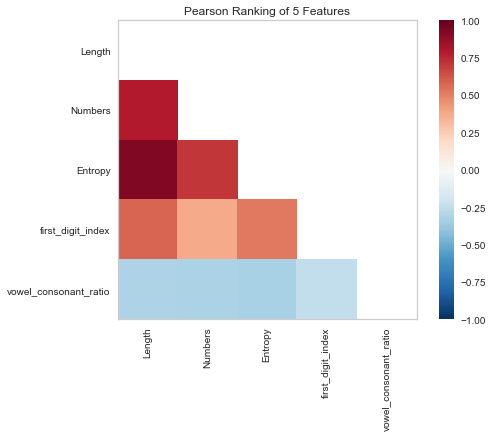

<AxesSubplot:title={'center':'Pearson Ranking of 5 Features'}>

In [35]:
# Correlation between two features using pearson
visualizer = Rank2D (algorithms = 'pearson', features = feature_names)
visualizer.fit_transform(features)
visualizer.poof()

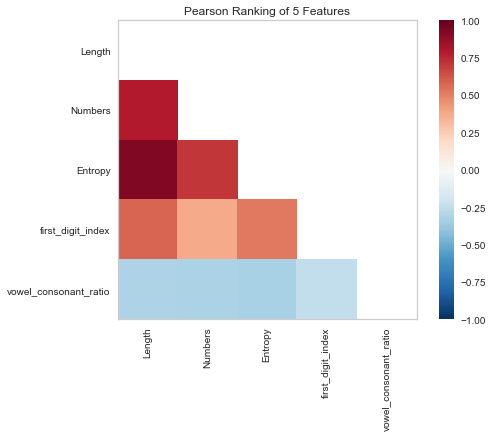

<AxesSubplot:title={'center':'Pearson Ranking of 5 Features'}>

In [37]:
#Correlation of two features using covariance
visualizer = Rank2D (algorithms = 'covariance', features = feature_names)
visualizer.fit_transform(features)
visualizer.poof()

/Users/hm/anaconda3/lib/python3.8/site-packages/yellowbrick/features/radviz.py:199: RuntimeWarning: invalid value encountered in true_divide
  xy = (s * row_).sum(axis=0) / row.sum()


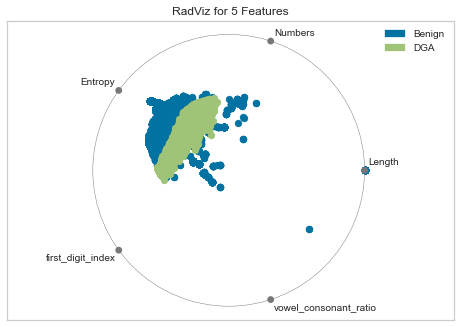

<AxesSubplot:title={'center':'RadViz for 5 Features'}>

In [46]:
# multivariate data visualization
X = domain_final[feature_names].to_numpy()
y = domain_final['IsDGA'].to_numpy()

radvisualizer = RadViz(classes = ['Benign', 'DGA'], features = feature_names )
radvisualizer.fit_transform(X, y)
radvisualizer.poof()

/Users/hm/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


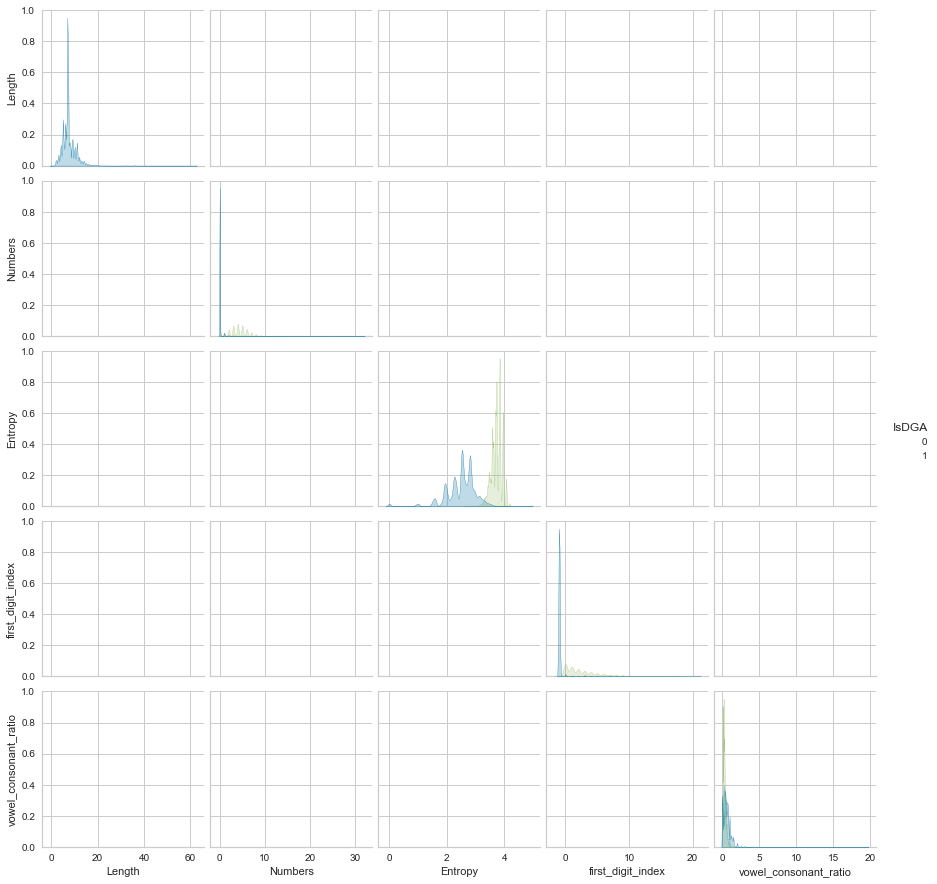

In [83]:
# Pairplots
g=sns.pairplot(domain_final, vars= feature_names, hue = 'IsDGA', kind='hex')
#g.set(ylim=(domain_final.min(['first_digit_index']).min(['first_digit_index'])))
#g.set(ylim=(data.min('first_digit_index').min(),data.max().max()))

<AxesSubplot:xlabel='Entropy', ylabel='Count'>

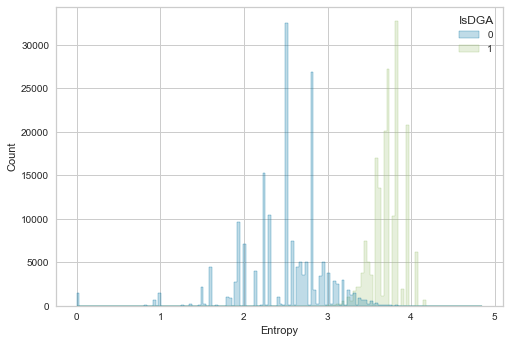

In [81]:
sns.histplot(domain_final, x="Entropy", hue="IsDGA", element="step")

<AxesSubplot:xlabel='Length', ylabel='Count'>

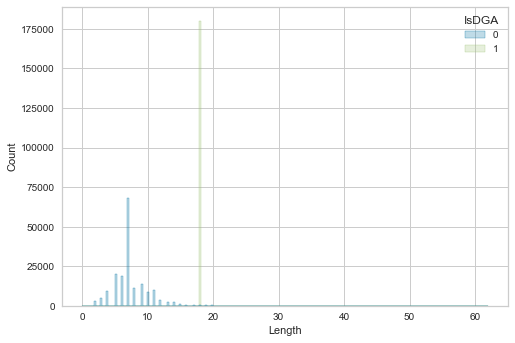

In [80]:
sns.histplot(domain_final, x="Length", hue="IsDGA", element="step")

<AxesSubplot:xlabel='first_digit_index', ylabel='Count'>

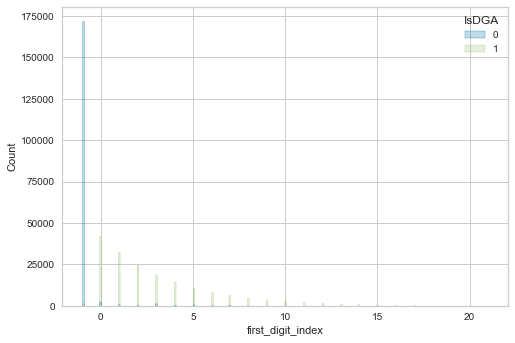

In [84]:
sns.histplot(domain_final, x="first_digit_index", hue="IsDGA", element="step")

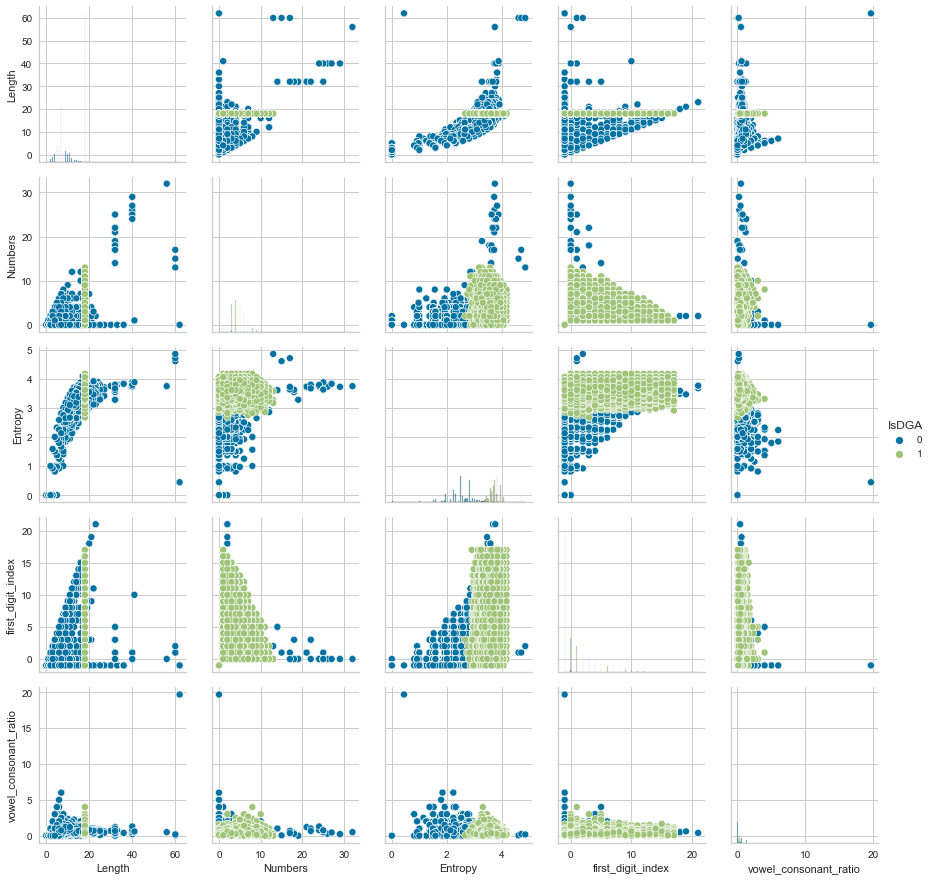

In [67]:
g = sns.PairGrid(domain_final, hue="IsDGA")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

<ipython-input-71-615aa34b96d0>:4: UserWarning: Attempting to set identical bottom == top == 18.0 results in singular transformations; automatically expanding.
  plt.ylim(min(y) - margin, max(y) + margin)


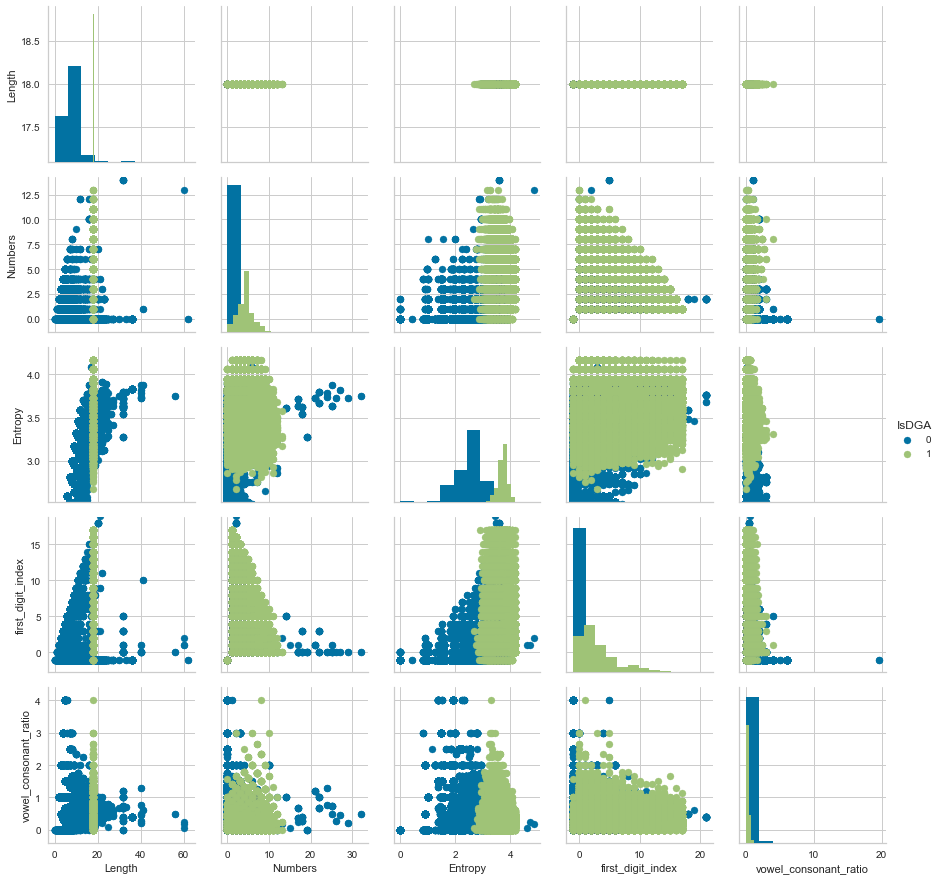

In [71]:
def better_scatter(x, y, **kwargs):
    plt.scatter(x, y, **kwargs)
    margin = (max(y) - min(y)) * 0.1
    plt.ylim(min(y) - margin, max(y) + margin)

g = sns.PairGrid(domain_final, hue="IsDGA")
g = g.map_diag(plt.hist)
g = g.map_offdiag(better_scatter)
g.add_legend()